# Описание проекта 

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Инструкция по выполнению проекта 

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

## Описание данных 

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')

import time
from datetime import timedelta

import pandas as pd
import numpy as np

from math import sqrt
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics.scorer import make_scorer


In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates = [0], index_col = 'datetime')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
df.sort_index(inplace=True)

In [7]:
print(df.index.is_monotonic)

True


- данные отсортированы

In [8]:
print('Первая дата = ', df.index.min())
print('Последняя дата = ', df.index.max())

Первая дата =  2018-03-01 00:00:00
Последняя дата =  2018-08-31 23:50:00


In [9]:
# выполним ресемплирование по одному часу.
df = df.resample('1H').sum()

In [10]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# Анализ

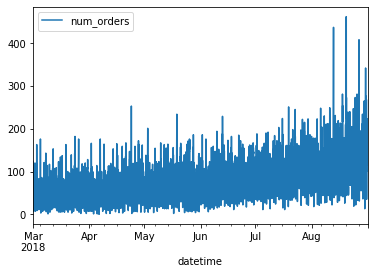

In [11]:
df.plot()

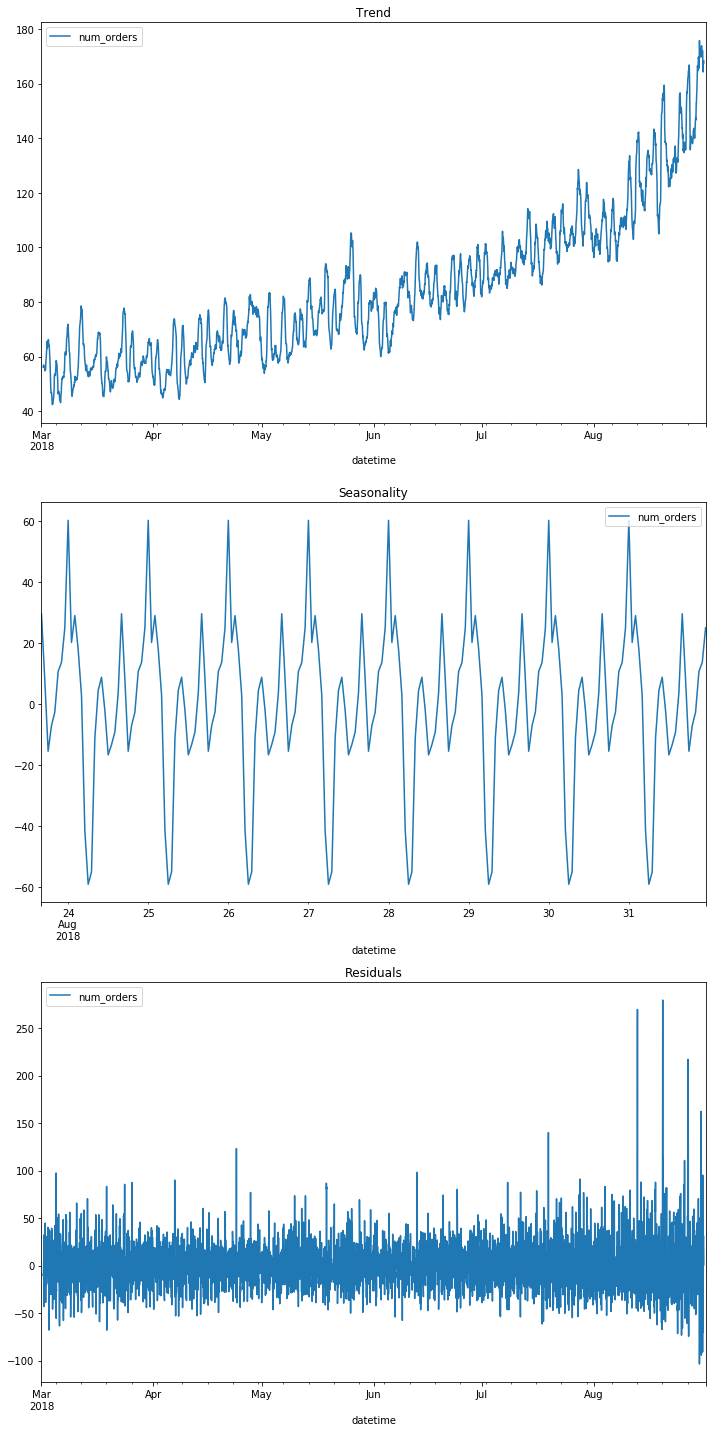

In [12]:
decomposed = seasonal_decompose(df) 

plt.figure(figsize=(10, 20))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.tail(200).plot(ax=plt.gca()) 

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 

plt.title('Residuals')
plt.tight_layout()

- тренд восходящий,
- есть сезонность. Период равен 24 часа.
- шум также присутствует.

# Обучение моделей

Рассмотрим следующие модели:
- LinearRegression (обучать смысла в этом разделе нет, т.к. гиперпараметры подбирать не будем),
- LGBMRegressor,
- CatBoostRegressor,
- XGBRegressor.

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [14]:
make_features(df, 100, 25)

In [15]:
# сделаем тестовую выборку размером 10% от исходных данных.
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [16]:
target_train = train['num_orders']
target_test = test['num_orders']

features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)

In [17]:
# создадим функцию вычисления rmse:
def rmse(target, prediction):
    mse = mean_squared_error(target, prediction)
    rmse = sqrt(mse)
    return rmse

# создадим параметр scorer:
scorer = make_scorer(rmse, greater_is_better=False)

In [18]:
# функция обучения модели на train выборке

def model_train(model, features_train, target_train):
    
    start_time = time.monotonic()
    model.fit(features_train,target_train)
    end_time = time.monotonic()

    time_fit = timedelta(seconds=end_time - start_time)
        
    start_time = time.monotonic()
    predictions = model.predict(features_train)
    end_time = time.monotonic()

    time_predict = timedelta(seconds=end_time - start_time)
    
    tss = TimeSeriesSplit(max_train_size=None, n_splits=3)
    final_score = cross_val_score(model, features_train, target_train, cv=tss , scoring=scorer).mean()

    return final_score, time_fit, time_predict, predictions

In [19]:
# функция тестирования модели на test выборке

def model_test(model, features_train, target_train, features_test, target_test):
    
    start_time = time.monotonic()
    model.fit(features_train,target_train)
    end_time = time.monotonic()

    time_fit = timedelta(seconds=end_time - start_time)
        
    start_time = time.monotonic()
    predictions = model.predict(features_test)
    end_time = time.monotonic()

    time_predict = timedelta(seconds=end_time - start_time)
      
    mse = mean_squared_error(target_test, predictions)
    rmse = sqrt(mse)    
    
    return rmse, time_fit, time_predict, predictions

## LGBMRegressor

In [37]:
%%time
best_result = 100000

for boosting_type in ['gbdt','dart','goss']:  #'gbdt','dart','goss'
    
    for n_estimators in range(1,202,50):
        
        model = lgb.LGBMRegressor(n_estimators = n_estimators, boosting_type = boosting_type, random_state=12345)
        rmse, time_fit, time_predict, predictions= model_train(model, features_train, target_train)  
        print(rmse, time_fit, time_predict)
        
        if abs(best_result) > abs(rmse):
            best_result = rmse
            best_boosting_type = boosting_type
            best_n_estimators = n_estimators
            best_time_fit = time_fit
            best_time_predict = time_predict
            
print('*' * 50)
print()

print('Лучший результат rmse =', abs(best_result), 'при boosting_type = ', best_boosting_type, 'и при n_estimators = ', best_n_estimators)
print('Время обучения модели c такими параметрами =', best_time_fit)
print('Время предсказания для модели c такими параметрами =', best_time_predict)

print('_ _ _ '*20)

-40.52686740229202 0:00:00.072846 0:00:00.015151
-25.518013436481954 0:00:00.627378 0:00:00.027094
-25.497547931529798 0:00:01.175474 0:00:00.040472
-25.494292298375825 0:00:01.550757 0:00:00.053569
-25.49586729303377 0:00:01.996771 0:00:00.066820
-40.52686740229202 0:00:00.073221 0:00:00.015190
-32.13817970206325 0:00:00.693270 0:00:00.025582
-27.25229060349012 0:00:01.377828 0:00:00.036501
-27.25397430920532 0:00:02.091008 0:00:00.046358
-26.4773359077502 0:00:02.799122 0:00:00.057278
-40.52686740229202 0:00:00.067455 0:00:00.014397
-2651146.5637054984 0:00:00.504885 0:00:00.026801
-2494217.8189128065 0:00:01.015861 0:00:00.041331
-638178374.4384552 0:00:01.449246 0:00:00.052235
-4665869973602069.0 0:00:02.041562 0:00:00.062843
**************************************************

Лучший результат rmse = 25.494292298375825 при boosting_type =  gbdt и при n_estimators =  151
Время обучения модели c такими параметрами = 0:00:01.550757
Время предсказания для модели c такими параметрами = 

## CatBoostRegressor

In [21]:
%%time
best_result = 100000

for iterations in range(1,102,50): 
    for depth in range(1,12,5):
        
        model = CatBoostRegressor(iterations = iterations, learning_rate = 0.1, depth = depth, random_state=12345)
        rmse, time_fit, time_predict, predictions= model_train(model, features_train, target_train)
        print(rmse, time_fit, time_predict)
        
        if abs(best_result) > abs(rmse):
            best_result = rmse
            best_depth = depth
            best_iterations = iterations
            best_time_fit = time_fit
            best_time_predict = time_predict
            
print('*' * 50)
print()

print('Лучший результат rmse =', abs(best_result), 'при depth = ', best_depth, 'и при iterations = ', best_iterations)
print('Время обучения модели c такими параметрами =', best_time_fit)
print('Время предсказания для модели c такими параметрами =', best_time_predict)

print('_ _ _ '*20)

0:	learn: 37.5678765	total: 48.2ms	remaining: 0us
0:	learn: 28.4610929	total: 1.11ms	remaining: 0us
0:	learn: 31.4181272	total: 925us	remaining: 0us
0:	learn: 33.0089587	total: 1.15ms	remaining: 0us
-41.955170961571156 0:00:00.999339 0:00:00.007891
0:	learn: 36.6943034	total: 9.18ms	remaining: 0us
0:	learn: 27.8666338	total: 7.2ms	remaining: 0us
0:	learn: 30.6731040	total: 5.91ms	remaining: 0us
0:	learn: 32.2620430	total: 7ms	remaining: 0us
-40.96925617769349 0:00:00.871271 0:00:00.007402
0:	learn: 36.6872417	total: 1.17s	remaining: 0us
0:	learn: 27.9356686	total: 535ms	remaining: 0us
0:	learn: 30.7381542	total: 915ms	remaining: 0us
0:	learn: 32.2331047	total: 808ms	remaining: 0us
-41.3490216318739 0:00:01.933569 0:00:00.008318
0:	learn: 37.5678765	total: 1.1ms	remaining: 55ms
1:	learn: 36.6157884	total: 2.32ms	remaining: 57ms
2:	learn: 35.7313935	total: 3.35ms	remaining: 53.7ms
3:	learn: 34.9219034	total: 4.65ms	remaining: 54.6ms
4:	learn: 34.1278506	total: 5.64ms	remaining: 51.9ms
5:

## XGBRegressor

In [22]:
%%time
best_result = 100000

for depth in range(1,12,5): 
    
    for n_estimators in range(1,102,50):
        
        model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth  = depth, verbosity = 0, random_state=12345)
        rmse, time_fit, time_predict, predictions= model_train(model, features_train, target_train)
        print(rmse, time_fit, time_predict)
        
        if abs(best_result) > abs(rmse):
            best_result = rmse
            best_depth = depth
            best_n_estimators = n_estimators
            best_time_fit = time_fit
            best_time_predict = time_predict
            
print('*' * 50)
print()

print('Лучший результат rmse =', abs(best_result), 'при max_depth  = ', best_depth, 'и при n_estimators = ', best_n_estimators)
print('Время обучения модели c такими параметрами =', best_time_fit)
print('Время предсказания для модели c такими параметрами =', best_time_predict)

print('_ _ _ '*20)

-86.21751802192284 0:00:00.041550 0:00:00.005632
-27.51110592862675 0:00:00.204998 0:00:00.007964
-26.08649490660755 0:00:00.363565 0:00:00.009722
-85.19101440800388 0:00:00.059939 0:00:00.006574
-26.335580275000098 0:00:01.109528 0:00:00.016270
-26.078787071859495 0:00:02.015422 0:00:00.027204
-85.43798871754886 0:00:00.088191 0:00:00.006415
-28.196467441947714 0:00:02.942636 0:00:00.029800
-27.81282997602595 0:00:04.980587 0:00:00.043789
**************************************************

Лучший результат rmse = 26.078787071859495 при max_depth  =  6 и при n_estimators =  101
Время обучения модели c такими параметрами = 0:00:02.015422
Время предсказания для модели c такими параметрами = 0:00:00.027204
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
CPU times: user 31.2 s, sys: 156 ms, total: 31.4 s
Wall time: 31.5 s


# Тестирование моделей с выбранными параметрами

In [23]:
# создадим пустые массивы для построения сравнительной таблицы
column_rmse = []
column_time_fit = []
column_time_predict = []

Запуск `LinearRegression` на тестовой выборке.

In [24]:
model = LinearRegression()

rmse, time_fit, time_predict, predictions= model_test(model, features_train, target_train, features_test, target_test)

column_rmse.append(abs(rmse))
column_time_fit.append(time_fit)
column_time_predict.append(time_predict)

print(rmse)

41.50656040311683


Запуск `CatBoostRegressor` на тестовой выборке с лучшими параметрами из предыдущего шага.

In [25]:
model = CatBoostRegressor(iterations = 101, learning_rate = 0.1, depth = 6, random_state=12345)
        
rmse, time_fit, time_predict, predictions= model_test(model, features_train, target_train, features_test, target_test)

column_rmse.append(abs(rmse))
column_time_fit.append(time_fit)
column_time_predict.append(time_predict)

print(rmse)

0:	learn: 36.6943034	total: 6ms	remaining: 600ms
1:	learn: 35.0243362	total: 11.5ms	remaining: 570ms
2:	learn: 33.6340059	total: 62.2ms	remaining: 2.03s
3:	learn: 32.2229366	total: 157ms	remaining: 3.8s
4:	learn: 31.0062947	total: 163ms	remaining: 3.13s
5:	learn: 30.0293524	total: 257ms	remaining: 4.07s
6:	learn: 29.1295193	total: 264ms	remaining: 3.54s
7:	learn: 28.2917303	total: 269ms	remaining: 3.13s
8:	learn: 27.5756429	total: 276ms	remaining: 2.82s
9:	learn: 26.9408889	total: 281ms	remaining: 2.56s
10:	learn: 26.3292353	total: 374ms	remaining: 3.06s
11:	learn: 25.8411453	total: 380ms	remaining: 2.82s
12:	learn: 25.4305976	total: 472ms	remaining: 3.2s
13:	learn: 25.0608820	total: 478ms	remaining: 2.97s
14:	learn: 24.6964304	total: 571ms	remaining: 3.27s
15:	learn: 24.3840358	total: 583ms	remaining: 3.1s
16:	learn: 24.1169803	total: 670ms	remaining: 3.31s
17:	learn: 23.9209999	total: 675ms	remaining: 3.11s
18:	learn: 23.6806644	total: 769ms	remaining: 3.32s
19:	learn: 23.4893049	tot

Запуск `XGBRegressor` на тестовой выборке с лучшими параметрами из предыдущего шага.

In [26]:
model = xgb.XGBRegressor(n_estimators = 101, max_depth  = 6, verbosity = 0, random_state=12345)

rmse, time_fit, time_predict, predictions= model_test(model, features_train, target_train, features_test, target_test)
        
column_rmse.append(abs(rmse))
column_time_fit.append(time_fit)
column_time_predict.append(time_predict)

print(rmse)

40.48124344220384


Запуск `LGBMRegressor` на тестовой выборке с лучшими параметрами из предыдущего шага.

In [36]:
model = lgb.LGBMRegressor(n_estimators = 151, boosting_type = 'gbdt', random_state=12345)

rmse, time_fit, time_predict, predictions= model_test(model, features_train, target_train, features_test, target_test)

column_rmse.append(abs(rmse))
column_time_fit.append(time_fit)
column_time_predict.append(time_predict)

print(rmse)

38.462785515701704


In [28]:
df_info = pd.DataFrame(np.array([column_rmse, column_time_fit, column_time_predict]),
                   columns=['LinearRegression', 'CatBoostRegressor', 'XGBRegressor', 'LGBMRegressor'], index=['rmse', 'time_fit', 'time_predict'])

In [29]:
df_info

,LinearRegression,CatBoostRegressor,XGBRegressor,LGBMRegressor
rmse,41.5066,39.5263,40.4812,38.3742
time_fit,0:00:00.060397,0:00:05.819647,0:00:02.006656,0:00:01.577457
time_predict,0:00:00.001725,0:00:00.005544,0:00:00.004304,0:00:00.014772


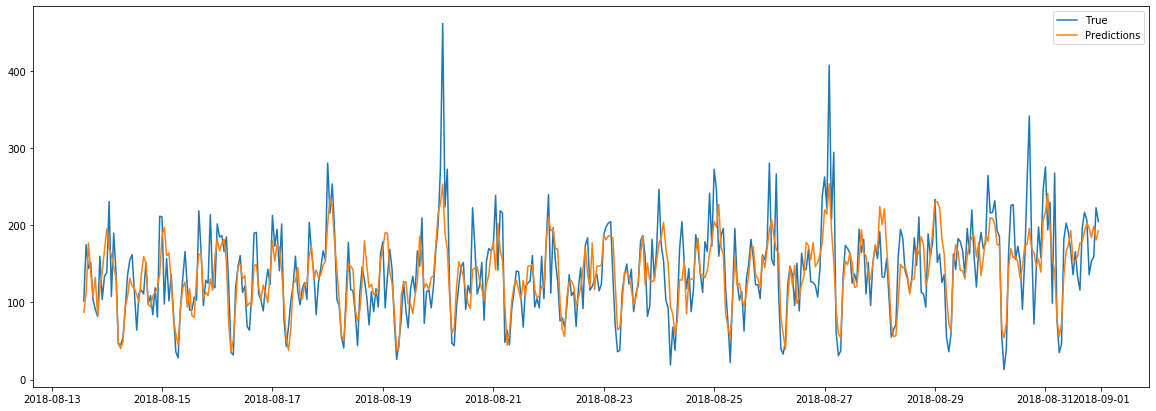

In [30]:
plt.figure(figsize=(20,7))
plt.plot(target_test, label = 'True')
plt.plot(target_test.index, predictions, label = 'Predictions')
plt.legend()
plt.show()

<b> Вывод: </b>
- в ходе проекта были изучены и проанализированы входные данные, выполнено их ресемплирование по одному часу.
- выявлен восходящий тренд,
- есть сезонность, период равен 24 часа,
- обучены разные модели с различными гиперпараметрами, при тестированнии которых выбрана `LGBMRegressor`.


<b>LGBMRegressor</b>
- <b>rmse</b> = `38.3742` (меньше, чем значение 48 по тех. заданию)
- <b>time_fit</b> = 02.126123
- <b>time_predict</b> = 00.016508
